# Analysis on One image

In [3]:
from pathlib import Path
import re

# If you know an exact filename, put it here. Otherwise leave as a hint fragment.
NAME_HINT = "AlphaEarth Embeddings 2024 Part 6"   # case-insensitive, partial ok
EXTS = (".tif", ".tiff")

def find_one_file(name_hint: str, exts=EXTS, start: Path | None = None) -> Path:
    """
    Search from current dir upward (and within each ancestor) for a file whose
    name contains `name_hint` (case-insensitive) and ends with one of `exts`.
    Returns the first match (closest to notebook).
    """
    if start is None:
        start = Path.cwd()
    patt = re.compile(re.escape(name_hint), re.IGNORECASE)
    # Search current dir and all descendants, then walk up parents
    for base in [start, *start.parents]:
        # 1) direct children
        for p in base.iterdir():
            if p.is_file() and p.suffix.lower() in exts and patt.search(p.stem):
                return p
        # 2) recursive
        for p in base.rglob("*"):
            try:
                if p.is_file() and p.suffix.lower() in exts and patt.search(p.stem):
                    return p
            except Exception:
                pass
    raise FileNotFoundError(f"No file matching '{name_hint}' with exts {exts} found from {start} upward.")

# Try to find the raster
TIF_PATH = find_one_file(NAME_HINT)
print("✅ Found raster:", TIF_PATH)

# Try to find the label_map JSON (optional)
def find_label_map(basename_hint="alpha_earth_test_set_1_label_map.json"):
    patt = re.compile(re.escape(basename_hint), re.IGNORECASE)
    for base in [Path.cwd(), *Path.cwd().parents]:
        for p in base.rglob("*.json"):
            if patt.search(p.name):
                return p
    return None

LABEL_MAP_PATH = find_label_map()
print("ℹ️ Label map:", LABEL_MAP_PATH if LABEL_MAP_PATH else "not found (optional)")



with rio.open(TIF_PATH) as ds:
    print("Path:", TIF_PATH)
    print("Driver:", ds.driver)
    print("Size (W,H):", ds.width, ds.height)
    print("Count (bands):", ds.count)
    print("CRS:", ds.crs)
    print("Transform:", ds.transform)
    print("Dtype:", ds.dtypes[0] if ds.count else None)
    print("Nodata:", ds.nodata)
    print("Bounds:", ds.bounds)


✅ Found raster: /app/datasets/AlphaEarth Embeddings 2024 Part 6.tif
ℹ️ Label map: /app/alpha_earth_test_set_1_label_map.json
Path: /app/datasets/AlphaEarth Embeddings 2024 Part 6.tif
Driver: GTiff
Size (W,H): 16 23
Count (bands): 65
CRS: EPSG:4326
Transform: | 0.00, 0.00,-6.29|
| 0.00,-0.00, 42.84|
| 0.00, 0.00, 1.00|
Dtype: float32
Nodata: None
Bounds: BoundingBox(left=-6.291440923859481, bottom=42.84191354105774, right=-6.29000361940489, top=42.84397966621122)


In [4]:
def band_stats(ds, band_idx, sample_cap=SAMPLE_PIXELS_FOR_STATS):
    # Read whole band (if small) or sampled windows (if large)
    W, H = ds.width, ds.height
    total_px = W * H
    step = max(1, int(math.sqrt(total_px / sample_cap))) if total_px > sample_cap else 1

    arr = ds.read(band_idx)[::step, ::step].astype(np.float32)
    if ds.nodata is not None:
        mask = arr != ds.nodata
    else:
        # assume NaNs indicate no-data; if none, all valid
        mask = ~np.isnan(arr)

    valid = arr[mask]
    if valid.size == 0:
        return dict(band=band_idx, min=np.nan, max=np.nan, mean=np.nan, std=np.nan, valid_pct=0.0)

    return dict(
        band=band_idx,
        min=float(np.min(valid)),
        max=float(np.max(valid)),
        mean=float(np.mean(valid)),
        std=float(np.std(valid)),
        valid_pct=100.0 * (valid.size / arr.size)
    )

with rio.open(TIF_PATH) as ds:
    rows = [band_stats(ds, b) for b in range(1, ds.count+1)]
stats_df = pd.DataFrame(rows).set_index("band")
stats_df


,min,max,mean,std,valid_pct
band,,,,,
1,0.017778,0.084214,0.047603,0.011296,72.01087
2,0.012057,0.130165,0.079462,0.017420,72.01087
3,-0.108512,0.048228,-0.045696,0.026697,72.01087
4,-0.002215,0.108512,0.041772,0.024748,72.01087
5,0.013841,0.088827,0.044223,0.018236,72.01087
...,...,...,...,...,...
61,0.075356,0.141730,0.108482,0.011453,72.01087
62,-0.071111,0.113741,0.034189,0.035036,72.01087
63,-0.022207,0.130165,0.087623,0.025714,72.01087


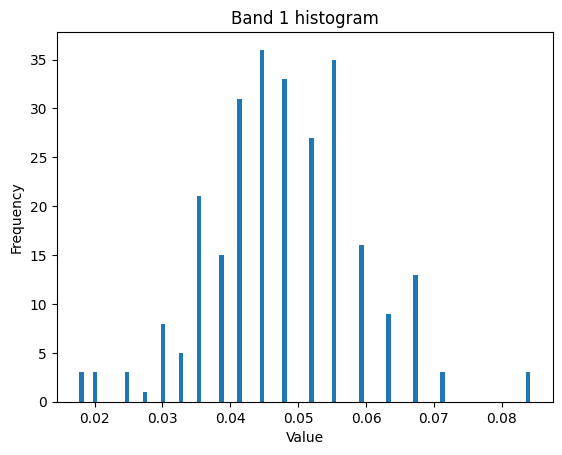

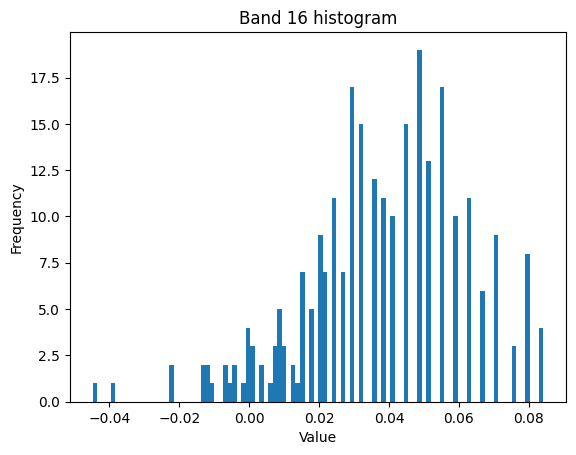

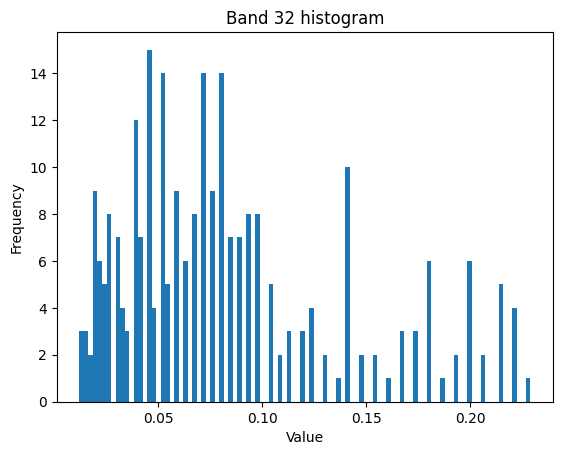

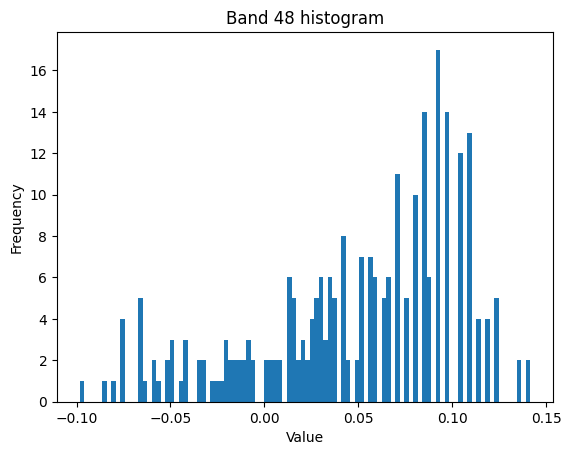

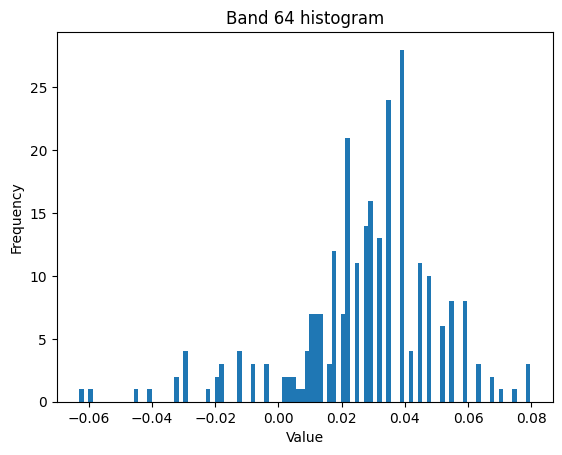

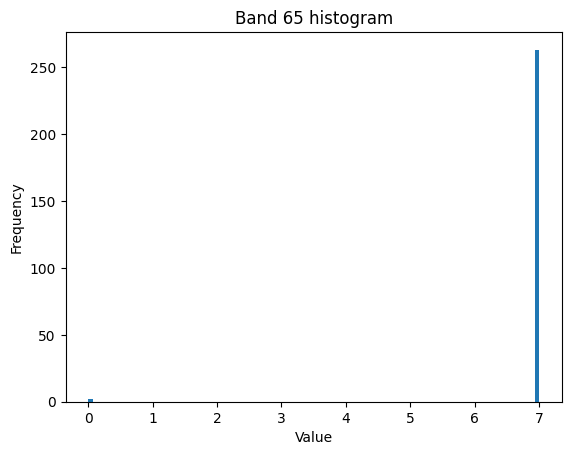

In [5]:
def plot_hist(ds, band_idx, bins=100, sample_cap=SAMPLE_PIXELS_FOR_STATS):
    W, H = ds.width, ds.height
    total_px = W * H
    step = max(1, int(math.sqrt(total_px / sample_cap))) if total_px > sample_cap else 1
    arr = ds.read(band_idx)[::step, ::step].astype(np.float32)
    if ds.nodata is not None:
        arr = arr[arr != ds.nodata]
    arr = arr[~np.isnan(arr)]
    plt.figure()
    plt.hist(arr.flatten(), bins=bins)
    plt.title(f"Band {band_idx} histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

with rio.open(TIF_PATH) as ds:
    # pick a few embedding bands spread across the 64
    picks = [1, 16, 32, 48, 64, LABEL_BAND_INDEX]
    for b in picks:
        if b <= ds.count:
            plot_hist(ds, b)


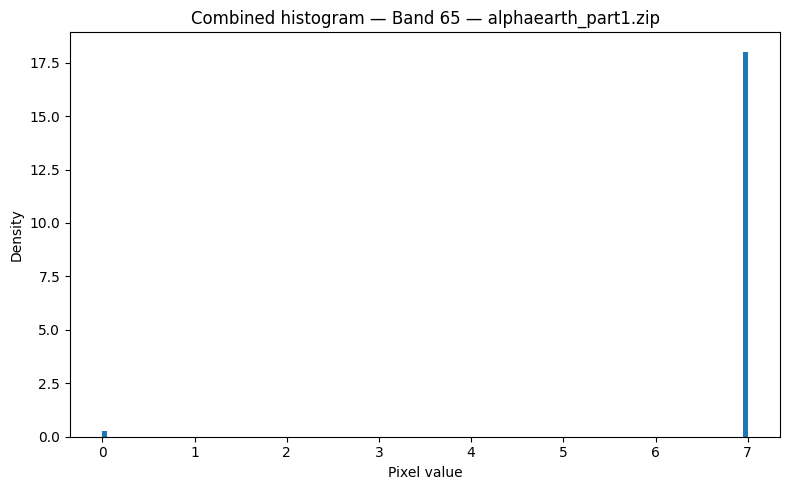

In [22]:
# =========================
# HISTOGRAMS OVER ALL TIFFs (uses your find_zip / vsizip_member)
# =========================
import math, zipfile
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

# Tunables
HIST_SAMPLE_CAP      = 5_000_000   # target max pixels sampled per raster (per band)
HIST_BINS            = 128
HIST_DENSITY         = True        # probability density; set False for counts
INCLUDE_LABEL_BAND   = False       # exclude band 65 by default in per-band mode
SAVE_PNGS            = False       # set True to save figures under OUT_DIR / "histograms"
PNG_DPI              = 120

(OUT_DIR / "histograms").mkdir(parents=True, exist_ok=True)

def _sample_band(ds: rio.io.DatasetReader, band_idx: int, sample_cap: int = HIST_SAMPLE_CAP) -> np.ndarray:
    """Return a 1D vector of sampled, valid (finite & !=nodata) pixel values for a band."""
    H, W = ds.height, ds.width
    total = H * W
    step = max(1, int(math.sqrt(total / sample_cap))) if total > sample_cap else 1
    arr = ds.read(band_idx)[::step, ::step].astype(np.float32)
    # nodata/NaN filter
    nod = ds.nodata
    if nod is not None:
        arr = arr[arr != nod]
    arr = arr[np.isfinite(arr)]
    return arr.reshape(-1)

def collect_zip_band_values(zip_name: str, band_idx: int | None = None, per_band: bool = False):
    """Collect values for a specific band across all TIFFs, or per-band dict if per_band=True."""
    zip_path = find_zip(zip_name)
    if zip_path is None:
        raise FileNotFoundError(f"Couldn't find {zip_name}. Put it under ./datasets/ or adjust ZIP_NAME.")

    with zipfile.ZipFile(zip_path, "r") as zf:
        members = [m for m in zf.namelist() if m.lower().endswith((".tif", ".tiff"))]
    if not members:
        raise RuntimeError("No .tif files inside the ZIP.")

    if band_idx is not None and per_band:
        raise ValueError("Choose either a specific band_idx or per_band=True, not both.")

    if band_idx is not None:
        chunks = []
        for m in members:
            vsi = vsizip_member(zip_path, m)
            try:
                with rio.open(vsi) as ds:
                    if not (1 <= band_idx <= ds.count):
                        continue
                    vals = _sample_band(ds, band_idx)
                    if vals.size:
                        chunks.append(vals)
            except Exception as e:
                print(f"⚠️ {m}: {e}")
        return np.concatenate(chunks) if chunks else np.array([], dtype=np.float32)

    if per_band:
        by_band: dict[int, list[np.ndarray]] = {}
        for m in members:
            vsi = vsizip_member(zip_path, m)
            try:
                with rio.open(vsi) as ds:
                    start_b = 1
                    end_b = ds.count
                    for b in range(start_b, end_b + 1):
                        if not INCLUDE_LABEL_BAND and 'LABEL_BAND_INDEX' in globals() and b == LABEL_BAND_INDEX:
                            continue
                        vals = _sample_band(ds, b)
                        if vals.size:
                            by_band.setdefault(b, []).append(vals)
            except Exception as e:
                print(f"⚠️ {m}: {e}")
        # concatenate
        return {b: np.concatenate(chunks) for b, chunks in by_band.items() if chunks}

    raise ValueError("Provide band_idx (int) or per_band=True.")

def plot_zip_histograms(zip_name: str, band_idx: int | None = None, per_band: bool = False,
                        bins: int = HIST_BINS, density: bool = HIST_DENSITY, save_pngs: bool = SAVE_PNGS):
    """Plot and optionally save histograms aggregated across all TIFFs in the ZIP."""
    title_stub = f"{zip_name}"
    if band_idx is not None:
        vals = collect_zip_band_values(zip_name, band_idx=band_idx, per_band=False)
        if vals.size == 0:
            raise RuntimeError(f"No values found for Band {band_idx}.")
        plt.figure(figsize=(8,5))
        plt.hist(vals, bins=bins, density=density)
        plt.title(f"Combined histogram — Band {band_idx} — {title_stub}")
        plt.xlabel("Pixel value"); plt.ylabel("Density" if density else "Count")
        plt.tight_layout()
        if save_pngs:
            out = OUT_DIR / "histograms" / f"hist_band{band_idx}.png"
            plt.savefig(out, dpi=PNG_DPI)
            print(f"💾 Saved {out}")
        plt.show()
        return

    if per_band:
        by_band = collect_zip_band_values(zip_name, per_band=True)
        if not by_band:
            raise RuntimeError("No per-band values found.")
        bands = sorted(by_band.keys())
        cols = min(3, len(bands))
        rows = math.ceil(len(bands) / cols)
        fig = plt.figure(figsize=(6*cols, 4*rows))
        for i, b in enumerate(bands, start=1):
            ax = fig.add_subplot(rows, cols, i)
            ax.hist(by_band[b], bins=bins, density=density)
            ax.set_title(f"Band {b}")
            ax.set_xlabel("Pixel value"); ax.set_ylabel("Density" if density else "Count")
        fig.suptitle(f"Per-band combined histograms — {title_stub}", y=0.98)
        plt.tight_layout()
        if save_pngs:
            out = OUT_DIR / "histograms" / f"hist_per_band_grid.png"
            fig.savefig(out, dpi=PNG_DPI)
            print(f"💾 Saved {out}")
        plt.show()
        return

    raise ValueError("Call with either band_idx=<int> or per_band=True")

# =========================
# EXAMPLES
# =========================
# 1) One combined histogram for Band 1 across ALL TIFFs
plot_zip_histograms(ZIP_NAME, band_idx=65, bins=128, density=True, save_pngs=False)

# 2) OR, per-band histograms across ALL TIFFs (skips label band 65 by default)
# plot_zip_histograms(ZIP_NAME, per_band=True, bins=128, density=True, save_pngs=True)


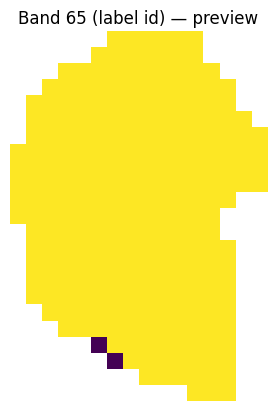

In [ ]:
with rio.open(TIF_PATH) as ds:
    scale = max(1, int(max(ds.width, ds.height) / PREVIEW_MAX_DIM))
    arr = ds.read(LABEL_BAND_INDEX)[::scale, ::scale]
    plt.figure()
    plt.imshow(arr)
    plt.title("Band 65 (label id) — preview")
    plt.axis("off")
    plt.show()


#Two Empty Pixels!!! Check why


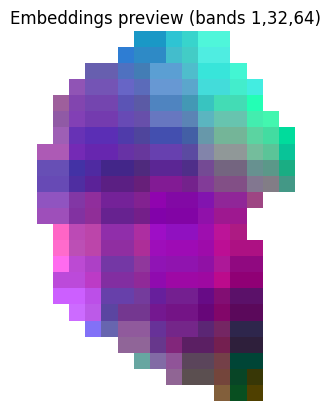

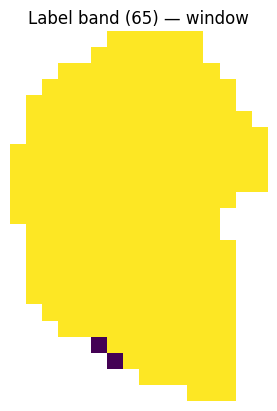

In [7]:
with rio.open(TIF_PATH) as ds:
    W, H = ds.width, ds.height
    w, h = min(128, W), min(128, H)
    col_off = max(0, (W - w) // 2)
    row_off = max(0, (H - h) // 2)
    win = Window(col_off, row_off, w, h)

    b1, b2, b3 = 1, 32, 64
    rgb = np.stack([ds.read(b1, window=win),
                    ds.read(b2, window=win),
                    ds.read(b3, window=win)], axis=-1).astype(np.float32)

    def norm01(x):
        x = x.copy()
        x -= np.nanmin(x)
        mx = np.nanmax(x) if np.nanmax(x) != 0 else 1.0
        return x / mx

    rgb_disp = np.dstack([norm01(rgb[...,0]), norm01(rgb[...,1]), norm01(rgb[...,2])])
    label = ds.read(LABEL_BAND_INDEX, window=win)

plt.figure(); plt.imshow(rgb_disp); plt.title(f"Embeddings preview (bands {b1},{b2},{b3})"); plt.axis("off"); plt.show()
plt.figure(); plt.imshow(label);    plt.title("Label band (65) — window");                 plt.axis("off"); plt.show()


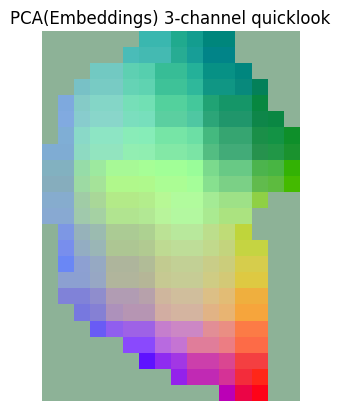

In [8]:
from sklearn.decomposition import PCA

with rio.open(TIF_PATH) as ds:
    W, H = ds.width, ds.height
    step = max(1, int(math.sqrt((W*H) / SAMPLE_PIXELS_FOR_PCA)))
    emb_stack = []
    for b in EMB_BANDS:
        emb_stack.append(ds.read(b)[::step, ::step].astype(np.float32))
    emb_arr = np.stack(emb_stack, axis=0)   # [64, h, w]
    h, w = emb_arr.shape[1:]
    X = emb_arr.reshape(len(EMB_BANDS), -1).T  # [N, 64]

mask = np.all(np.isfinite(X), axis=1)
Xc = X[mask]
Xc = Xc - Xc.mean(axis=0, keepdims=True)

pca = PCA(n_components=3, svd_solver="randomized", random_state=0)
Y = pca.fit_transform(Xc)

Yimg = np.zeros((h*w, 3), dtype=np.float32)
Yimg[mask] = Y
Yimg = Yimg.reshape(h, w, 3)

def scale01(a):
    a = a.copy()
    mn, mx = np.nanmin(a), np.nanmax(a)
    return (a - mn) / (mx - mn) if mx > mn else np.zeros_like(a)

Ydisp = np.dstack([scale01(Yimg[...,0]),
                   scale01(Yimg[...,1]),
                   scale01(Yimg[...,2])])

plt.figure(); plt.imshow(Ydisp); plt.title("PCA(Embeddings) 3-channel quicklook"); plt.axis("off"); plt.show()


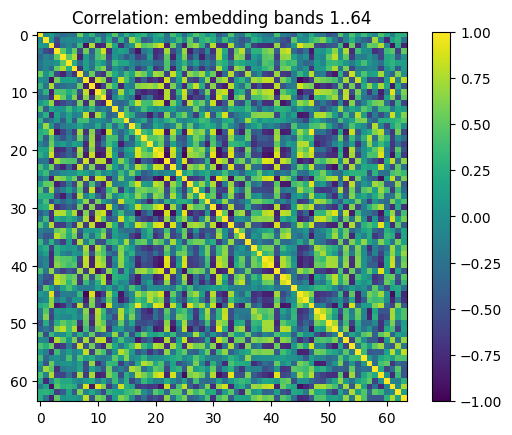

In [9]:
with rio.open(TIF_PATH) as ds:
    W, H = ds.width, ds.height
    step = max(1, int(math.sqrt((W*H) / SAMPLE_PIXELS_FOR_STATS)))
    emb_stack = []
    for b in EMB_BANDS:
        emb_stack.append(ds.read(b)[::step, ::step].astype(np.float32))
    emb_arr = np.stack(emb_stack, axis=0)   # [64, h, w]
    X = emb_arr.reshape(len(EMB_BANDS), -1).T  # [N, 64]
    X = X[np.all(np.isfinite(X), axis=1)]
    if X.shape[0] > SAMPLE_PIXELS_FOR_STATS:
        sel = np.random.choice(X.shape[0], SAMPLE_PIXELS_FOR_STATS, replace=False)
        X = X[sel]

corr = np.corrcoef(X, rowvar=False)  # [64,64]
plt.figure(); plt.imshow(corr, vmin=-1, vmax=1); plt.title("Correlation: embedding bands 1..64"); plt.colorbar(); plt.show()
